## Mathematical formulation

### Unit length streets

The vector of trip request rates is $\lambda$, and the vector of taxi densities (not including the taxi in consideration) is $\rho$. We assume that the probability a particular taxi gets a trip is the probability a trip is generated ($\lambda$) times the probability that taxi is picked $\left(\frac{1}{\rho+1}\right)$. Let $\Pi_\rho$ be the policy followed when densities are at $\rho$. Let $\rho'$ be the new densities after one timestep has passed. $\rho'=\Pi_\rho\max(0, \rho - 1)$ assuming that all cars move to another road within the next timestep except the one that picked up a passenger. Then the expected waiting time for a taxi introduced at a node $i$ is given by $x_i$ where
$$ x_\rho = \frac{\lambda}{\rho + 1} + \left(1 - \frac{\lambda}{\rho + 1}\right) \Pi_{\rho'}^Tx_{\rho'} $$

The policy matrix $\Pi_\rho$ is just $x_\rho$ multiplied columnwise on the adjacency matrix. 

This is finding the nash equilibrium greedy strategy, not the true shared strategy

A function approximator should be able to use only entries of $\rho$ in a small radius of $i$ to find $x_i$. Might learn better. 

We ideally want to find the time incurred for EVERYONE if a new car is deployed to a place

## Make a 2D example for testing

In [1]:
using Laplacians: grid2
using Knet, Distributions

In [2]:
const A = grid2(10);

In [3]:
const roads = size(A)[1];
const lam = max.(rand(roads) / 5, 1e-9);

## Policy Utils

In [4]:
function fixedPoint(f, initial)
  while true
    newval = f(initial)
    if isapprox(newval, initial)
      return newval
    end
    initial = newval
  end
end

fixedPoint (generic function with 1 method)

In [5]:
function scorePolicy(scores)
  r = spdiagm(scores) * A
  r * spdiagm(1./ reshape(sum(r, 1), :))
end

scorePolicy (generic function with 1 method)

In [23]:
ptrPolicy(ptrs) = sparse(ptrs, 1:roads, ones(roads), roads, roads)

ptrPolicy (generic function with 1 method)

In [7]:
function neighborMin(A::SparseMatrixCSC{Float64,Int},v::Array{Float64,1})
    w = zeros(Int,A.m)
    c = fill(Inf64, A.m)
    for vi in 1:A.m
        for ind in A.colptr[vi]:(A.colptr[vi+1]-1)
            nbr = A.rowval[ind]
            newval =v[nbr]
            if newval <= c[vi]
                c[vi] = newval
                w[vi] = nbr
            end
        end
    end
    @assert ~any(isinf.(c))
    (c, w)
end

neighborMin (generic function with 1 method)

## Single agent dynamic programming

In [8]:
# Proportional dispatch
singlePolPropM = scorePolicy(1 ./ fixedPoint(x-> lam .+ (1 .- lam) .* (scorePolicy(x).' * x), 1./ lam));
singlePolProp(_) = singlePolPropM;

In [24]:
# Greedy dispatch
singlePolMaxM = ptrPolicy(neighborMin(A, fixedPoint(x->lam .+ (1 .- lam) .* (1 .+ neighborMin(A, x)[1]), 1 ./ lam))[2]);
singlePolMax(_) = singlePolMaxM;

## Train the multi-agent policy with a neural net

In [4]:
w = 0.1*randn(roads, roads);
b = fill(1.0, roads);
model = (w,b);

In [6]:
o = optimizers(model, Adam);

In [7]:
predict(params, rho) = max.(0, params[1] * rho .+ params[2])

predict (generic function with 1 method)

In [8]:
function loss(params, rho)
  timeEst = predict(params, rho)
  pol = makePolicy(getval(timeEst))
  p = lam ./ (rho .+ 1)
  newRho = pol * max.(0, rho .- 1)
  newEst = predict(params, newRho)
  newPol = makePolicy(getval(newEst))
  unlucky = (1 .- p) .* (newPol' * newEst)
  mean(abs2, p + unlucky - timeEst)
end

lossFn = gradloss(loss);

In [9]:
function train()
  running_loss = 0.0
  for i in 1:5000
    rho = trunc.(min.(10.0, randexp(roads) .* 5))
    g, l = lossFn(model, rho)
    running_loss += l
    if i % 100 == 0
      println(running_loss / 100.0)
      running_loss = 0.0
    end
    update!(model, g, o)
  end
end

train (generic function with 1 method)

In [10]:
train()

1.0788152757302674
0.38696774281896906
0.24410167433401203
0.1554605609001662
0.10433745941283329
0.07197814709288955
0.04723616617750756
0.036226170285979735
0.02766435582191134
0.020415824079971286
0.01807676831349987
0.01826427114326385
0.017569981721092864
0.0144579885134201
0.011588647852249194
0.009908531844787937
0.011380223263688293
0.010236892927959724
0.00852234475029963
0.013677041508392211
0.009037156202051802
0.00969845335830429
0.008998285414290288
0.0065153389672372745
0.008396550926877556
0.00709153722949981
0.004426843036018292
0.010028697823935888
0.0061239794668948135
0.005661408748029023
0.006894288068440835
0.005797201946460047
0.004241351880737388
0.005471857304162879
0.003575072165747104
0.004316797037121418
0.004954013189768592
0.005069019401448774
0.0043832315338216835
0.004874049879760897
0.004494703819990189
0.003143253308740851
0.0037694529670302
0.003885977602832832
0.0038354487699149243
0.004471738903213887
0.004875801263293774
0.004017156710445397
0.00405

## Comparison

Debugging starts here

In [10]:
using PyPlot

In [11]:
samplePolicy(m, rho) =
  sum(rand(Multinomial(r, full(m[:,i]))) for (i, r) in enumerate(rho));

In [12]:
# This uses the unit-time roads assumption.
function timeTilPickup(f, rho)
  remaining = sum(rho)
  finishTimes = zeros(remaining)
  i = 0
  while remaining >= 1
    finished = (rho .>= 1) .& (rand(roads) .< lam)
    done = sum(finished)
    # @assert(done <= remaining)
    newrho = rho .- finished
    finishTimes[remaining-done+1:remaining] = i
    remaining -= done
    rho = f(newrho) * newrho
    rho = samplePolicy(f(newrho), newrho)  
    # @assert(isapprox(sum(rho), sum(newrho)))
    i += 1
  end
  finishTimes
end

timeTilPickup (generic function with 1 method)

In [17]:
randPolM = scorePolicy(ones(roads));
randPol(_) = randPolM;

In [14]:
greedyPolM = ptrPolicy(neighborMin(A, 1 ./ lam)[2]);
greedyPol(_) = greedyPolM

greedyPol (generic function with 1 method)

In [ ]:
# We're doing SO much worse than random.
# Perhaps we're finding the worst policy instead of the best?

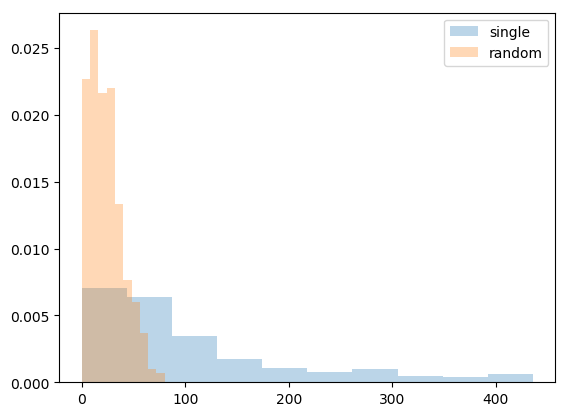

In [26]:
rho = trunc.(Int, min.(10.0, randexp(roads) .* 5))
plt[:hist](timeTilPickup(singlePolMax, rho), normed=true, alpha=0.3);
plt[:hist](timeTilPickup(randPol, rho), normed=true, alpha=0.3);
plt[:legend](["single", "random"]);

In [ ]:
greedyPolProp = constant(scorePolicy(lam));
greedyPolMax = constant(ptrPolicy(neighborMin(A, 1 ./ lam)[2]))

In [ ]:
# Stopped here

In [19]:
probA = spdiagm(lam) * A;
best = @views [findmax(probA[:,i])[2] for i in 1:roads]
greedyPol = sparse(best, 1:roads, ones(roads), roads, roads);
greedy(_) = greedyPol

greedy (generic function with 1 method)

In [16]:
function modelPolicy(rho)
  return makePolicy(predict(model, rho))
end

modelPolicy (generic function with 1 method)

In [ ]:
# is there a basin where they all end up?

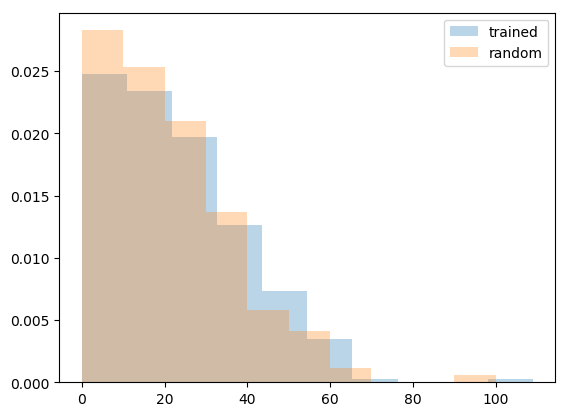

In [46]:
rho = trunc.(Int, min.(10.0, randexp(roads) .* 5))
plt[:hist](timeTilPickup(modelPolicy, rho), normed=true, alpha=0.3);
# plt[:hist](timeTilPickup(greedy), normed=true, alpha=0.3);
plt[:hist](timeTilPickup(randPol), normed=true, alpha=0.3);
plt[:legend](["trained", "random"]);